## Imports

In [1]:
import sys
sys.path.append('../../MSongsDB/PythonSrc') 

import dill as pickle
import numbers
import operator
import time
import pdb
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool as ThreadPool
from hdf5_getters import *

## Utils

In [2]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def process_h5(h5):
    h5 = open_h5_file_read(h5)
    parsed = parse_h5(h5)
    h5.close()
    return parsed

def parse_h5(h5):
    return {
        'path': msd_id_to_dirs(get_song_id(h5)),
        'audio_md5': get_audio_md5(h5),
        'song_year': get_year(h5),
        'song_title': get_title(h5),
        'song_id': get_song_id(h5),
        'song_time_signature': get_time_signature(h5),
        'song_time_signature_confidence': get_time_signature_confidence(h5),
        'song_tempo': get_tempo(h5),
        'song_key': get_key(h5),
        'song_key_confidence': get_key_confidence(h5),
        'song_mode': get_mode(h5),
        'song_mode_confidence': get_mode_confidence(h5),
        'song_loudness': get_loudness(h5),
        'song_energy': get_energy(h5),
        'song_duration': get_duration(h5),
        'song_danceability': get_danceability(h5),
        'song_hotttnesss': get_song_hotttnesss(h5),
        'song_segments_start': get_segments_start(h5),
        'song_segments_confidence': get_segments_confidence(h5),
        'song_sections_start': get_sections_start(h5),
        'song_sections_confidence': get_sections_confidence(h5),
        'artist_id': get_artist_id(h5),
        'artist_mbid': get_artist_mbid(h5),
        'artist_name': get_artist_name(h5),
        'artist_terms': get_artist_terms(h5),
        'artist_terms_frequency': get_artist_terms_freq(h5),
        'artist_terms_weight': get_artist_terms_weight(h5),
        'artist_mbtags': get_artist_mbtags(h5),
        'artist_hotttnesss': get_artist_hotttnesss(h5),
        'artist_familiarity': get_artist_familiarity(h5),
        'artist_location': get_artist_location(h5)
    }

def query_dict_array(arr, query):
    
    if type(query) != list:
        query = [query]
    
    def array_filter(data):
        for q in query:
            t = 'OR'
            if 'type' in q:
                if q['type'].upper() == 'AND':
                    t = 'AND'    
            for key in q:
                
                if key == 'type':
                    continue
                
                if t == 'OR':
                    if type(q[key]) == str or isinstance(q[key], numbers.Number):
                        if type(data[key]) == str or isinstance(data[key], numbers.Number):
                            if q[key] == data[key]:
                                return True
                        elif type(data[key]) == list or type(data[key]) == np.ndarray:
                            if q[key] in data[key]:
                                return True
                    elif type (q[key]) == list:
                        for v in q[key]:
                            if type(data[key]) == str or isinstance(v, numbers.Number):
                                if v == data[key]:
                                    return True
                            elif type(data[key]) == list or type(data[key]) == np.ndarray:
                                if v in data[key]:
                                    return True
                    elif callable(q[key]):
                        if q[key](data[key]):
                            return True
                else:
                    if type(q[key]) == str or isinstance(q[key], numbers.Number):
                        if type(data[key]) == str or isinstance(data[key], numbers.Number):
                            if q[key] != data[key]:
                                return False
                        elif type(data[key]) == list or type(data[key]) == np.ndarray:
                            if q[key] not in data[key]:
                                return False
                    elif type (q[key]) == list:
                        for v in q[key]:
                            if type(data[key]) == str or isinstance(v, numbers.Number):
                                if v != data[key]:
                                    return False
                            elif type(data[key]) == list or type(data[key]) == np.ndarray:
                                if v not in data[key]:
                                    return False
                    elif callable(q[key]):
                        if not q[key](data[key]):
                            return False
            if t == 'AND':
                return True
        return False

    return filter(array_filter, arr)

def get_array_freq(msd, field='artist_terms'):
    freqs = {}
    for s in msd:
        for t in s[field]:
            if t not in freqs:
                freqs[t] = 0
            freqs[t] = freqs[t] + 1
    return freqs
    
def get_freq(msd, field):
    years = {}
    for s in msd:
        if s[field] not in years:
            years[s[field]] = 0
        years[s[field]] = years[s[field]] + 1
    return years

## Load and parse Million Song Dataset

In [3]:
h5_dir = '/home/bbpwn/Documents/code/midi-dataset/data/lmd_matched_h5'
h5_files = glob.glob('{}/*/*/*/*.h5'.format(h5_dir))
start_time = time.time()

Singlethreaded loading

In [4]:
# msd = []
# for i, h5 in enumerate(h5_files):
#     meta.append(process_h5(h5))
#     if i % 100 == 0:
#         print(i)

Multithreaded loading

In [5]:
# num_threads = 8
# pool = ThreadPool(num_threads)
# msd = pool.map(process_h5, h5_files)

Load/save from pickle

In [6]:
## Uncomment to save msd as pickle
# with open('msd.pickle', 'w') as f:
#     pickle.dump(msd, f)

with open('msd.pickle', 'r') as f:
    msd = pickle.load(f)

In [7]:
print('Loaded in {:.2f} seconds'.format(time.time() - start_time))

Loaded in 22.26 seconds


## Plotting

In [8]:
year_freq = get_freq(msd, 'song_year')
key_freq = get_freq(msd,  'song_key')
terms_freq = get_array_freq(msd, 'artist_terms')
mbtags_freq = get_array_freq(msd, 'artist_mbtags')

# above dict items can be sorted into a list of tuples later with
# sorted_terms_freq = sorted(terms_freq.items(), key=operator.itemgetter(1))

In [9]:
sorted_terms_freq = sorted(terms_freq.items(), key=operator.itemgetter(1), reverse=True)[:100]
sorted_mbtags_freq = sorted(mbtags_freq.items(), key=operator.itemgetter(1), reverse=True)[:100]
sorted_key_freq = sorted(key_freq.items(), key=operator.itemgetter(1), reverse=True)
# sorted_year_freq = sorted(year_freq.items(), key=operator.itemgetter(1), reverse=True)

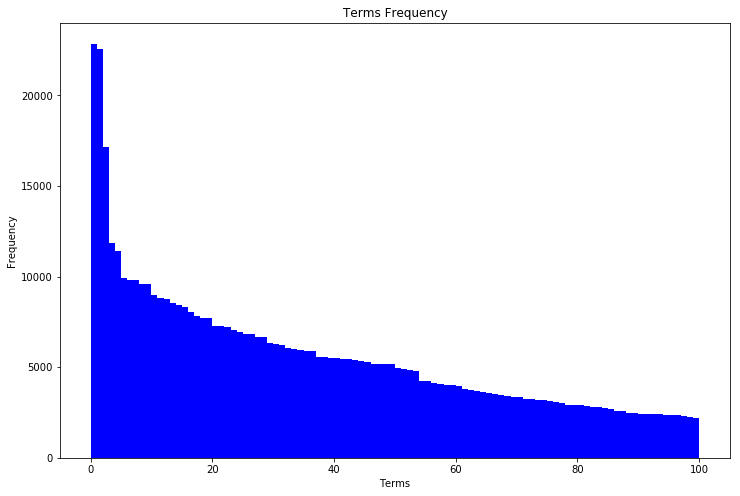

In [10]:
plt.rcParams["figure.figsize"] = (12, 8)

plt.bar(range(0, len(sorted_terms_freq)), 
        [y for x, y in sorted_terms_freq], 
        align='edge', width=1.0, color='blue')
plt.title('Terms Frequency')
plt.ylabel('Frequency')
plt.xlabel('Terms')
plt.show()

In [11]:
for i, v in list(enumerate(sorted_terms_freq))[:50]:
    print('{}. {} {}'.format(str(i + 1).rjust(3), v[0].ljust(20), v[1]))

  1. rock                 22846
  2. pop                  22548
  3. electronic           17167
  4. pop rock             11864
  5. jazz                 11403
  6. alternative rock     9892
  7. ballad               9823
  8. hip hop              9816
  9. soul                 9607
 10. disco                9572
 11. vocal                8980
 12. classic rock         8821
 13. house                8772
 14. alternative          8517
 15. folk                 8445
 16. united states        8343
 17. soundtrack           8059
 18. soft rock            7827
 19. country              7705
 20. electro              7688
 21. synthpop             7295
 22. funk                 7263
 23. techno               7219
 24. blues                7024
 25. germany              6924
 26. downtempo            6852
 27. easy listening       6849
 28. 80s                  6681
 29. indie                6669
 30. acoustic             6313
 31. guitar               6296
 32. classic              6238
 33

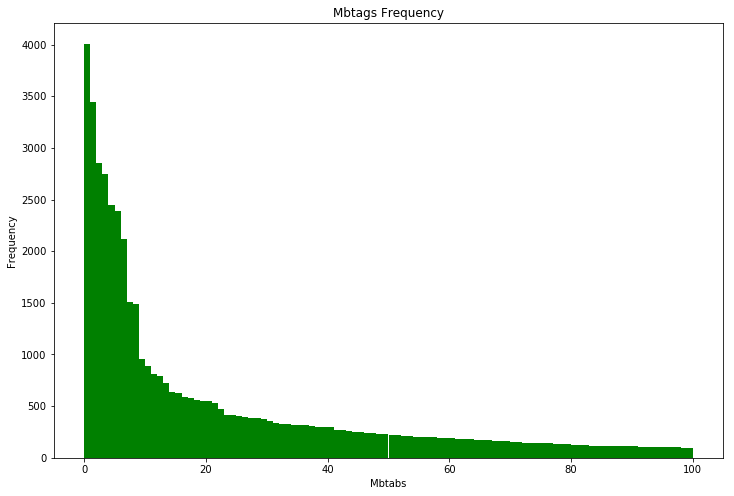

In [12]:
plt.bar(range(0, len(sorted_mbtags_freq)), 
        [y for x, y in sorted_mbtags_freq], 
        align='edge', width=1.0, color='green')
plt.title('Mbtags Frequency')
plt.ylabel('Frequency')
plt.xlabel('Mbtabs')
plt.show()

In [13]:
for i, v in list(enumerate(sorted_mbtags_freq))[:50]:
    print('{}. {} {}'.format(str(i + 1).rjust(3), v[0].ljust(27), v[1]))

  1. classic pop and rock        4009
  2. rock                        3445
  3. american                    2854
  4. british                     2750
  5. uk                          2445
  6. pop                         2392
  7. english                     2116
  8. pop and chart               1509
  9. rock and indie              1486
 10. electronic                  952
 11. alternative rock            889
 12. european                    813
 13. folk                        791
 14. usa                         728
 15. german                      633
 16. hard rock                   631
 17. classical                   593
 18. metal                       578
 19. country                     557
 20. french                      554
 21. américain                  548
 22. pop rock                    529
 23. rnb                         474
 24. hip hop rnb and dance hall  414
 25. new wave                    410
 26. jazz                        402
 27. united states            

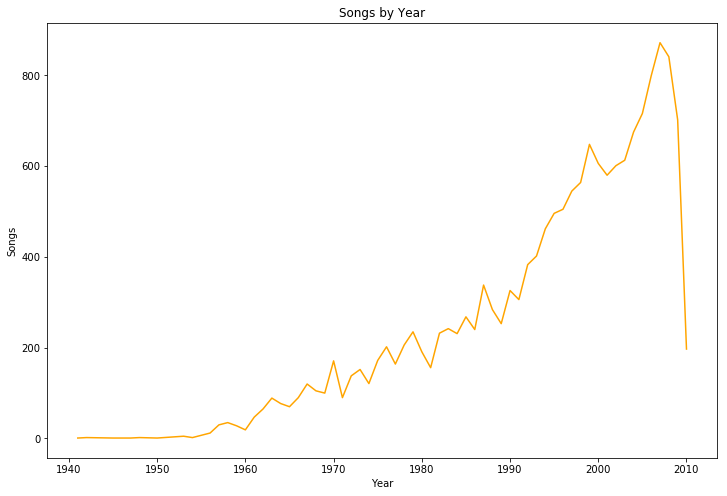

In [14]:
year_freq.pop(0, None)
plt.plot(list(year_freq.keys()), list(year_freq.values()), 
         color='orange')
plt.title('Songs by Year')
plt.ylabel('Songs')
plt.xlabel('Year')
plt.show()

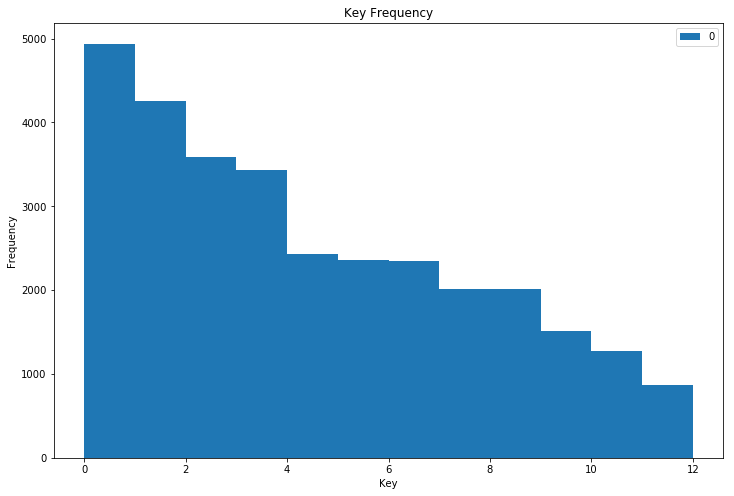

In [15]:
plt.bar(range(0, len(sorted_key_freq)), 
        [y for x, y in sorted_key_freq], 
        align='edge', width=1.0)
plt.title('Key Frequency')
plt.ylabel('Frequency')
plt.xlabel('Key')
plt.legend([x for x, y in sorted_key_freq])
plt.show()

## Query dataset

In [16]:
query = {
    'type': 'AND',
    'song_hotttnesss': lambda hotttnesss: hotttnesss > 0.5,
    'artist_terms': ['punk'],
  }

results = query_dict_array(msd, query)
print(len(results))
# test = list([r['artist_terms'].tolist() for r in results])


1755
